In [2]:
# common imports
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier, cv, DMatrix
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn import metrics
from sklearn import clone # 'clone' constructs a new unfitted estimator with the same parameters.
from sklearn.dummy import DummyClassifier
from scipy.ndimage.interpolation import shift

# display setup
plt.style.use('seaborn')  # for plots
import warnings

# warnings.filterwarnings(action='ignore', category=UserWarning)

# Preface
* Fashion-MNIST is a dataset containing 70,000 samples, 60,000 for the training set and 10,000 for the test set.
* Each sample is a 28x28 (784 pixels) grayscale image of a certain fashion item.
* The data contains a column with 10 labels, making this a **multiclass classification** problem.
In other words, this is a **supervised learning** task.
* The model will be trained using all available data and run without learning anymore, also known as **offline/batch learning**.
* Main objective: Find the best algorithm and model parameters that classify the unseen images correctly.

# 1. Getting the Data

In [3]:
# read the csv file
train_set = pd.read_csv(r"FMNIST/fashion-mnist_train.csv")
test_set = pd.read_csv(r"FMNIST/fashion-mnist_test.csv")

In [4]:
# display the first 5 rows for a quick look
train_set.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# display the last 5 rows for a quick look
train_set.tail()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59999,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# DataFrame shape (rows, columns)
print("Training Set:", train_set.shape)
print("Test Set:", test_set.shape)

Training Set: (60000, 785)
Test Set: (10000, 785)


In [7]:
# description of data
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [8]:
# summary of the numerical attributes
# null values are ignored
train_set.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000
mean,4.500000,0.000900,0.006150,0.035333,0.101933,0.247967,0.411467,0.805767,2.198283,5.682000,...,34.625400,23.300683,16.588267,17.869433,22.814817,17.911483,8.520633,2.753300,0.855517,0.07025
std,2.872305,0.094689,0.271011,1.222324,2.452871,4.306912,5.836188,8.215169,14.093378,23.819481,...,57.545242,48.854427,41.979611,43.966032,51.830477,45.149388,29.614859,17.397652,9.356960,2.12587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,9.000000,16.000000,36.000000,226.000000,164.000000,227.000000,230.000000,224.000000,255.000000,254.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,170.00000


In [9]:
# maximum pixel value
train_set.describe().loc['max'].max()

255.0

In [10]:
# minimum pixel value
train_set.describe().loc['min'].max()

0.0

> ### Features in the DataFrame:
> There are 785 columns, one for the labels and 784 for the pixels (one for each pixel).
>> Labels:
> - 0 = T-shirt/top
> - 1 = Trouser
> - 2 = Pullover
> - 3 = Dress
> - 4 = Coat
> - 5 = Sandal
> - 6 = Shirt
> - 7 = Sneaker
> - 8 = Bag
> - 9 = Ankle boot

In [11]:
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
# number of instances for each category
train_set["label"].value_counts().sort_index()

0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: label, dtype: int64

> Initial observations:
1. Each category has an equal amount of samples in the training set.
2. Classes and pixel values are integers.
3. The pixel range is [0, 255]. Some feature columns have a smaller maximum value or a
greater minimum value. This means that for some pixels, the range of the values is smaller.

# 2. Understanding and Visualizing the Data
> ##### *The motivation for this section is to gain more insights.*

The data was split in advance and the images are already the same aspect ratio.
Let's create a copy of the data to prevent accidentally harming the training set.

In [12]:
# deep copy of the training set
fmnist = train_set.copy()

In [13]:
fmnist.head(2)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# check for missing values
np.isnan(fmnist.values).sum()

0

> #### Observations:
> * There are no missing values in the training set.

> ### Exploring Colors of Sample Image

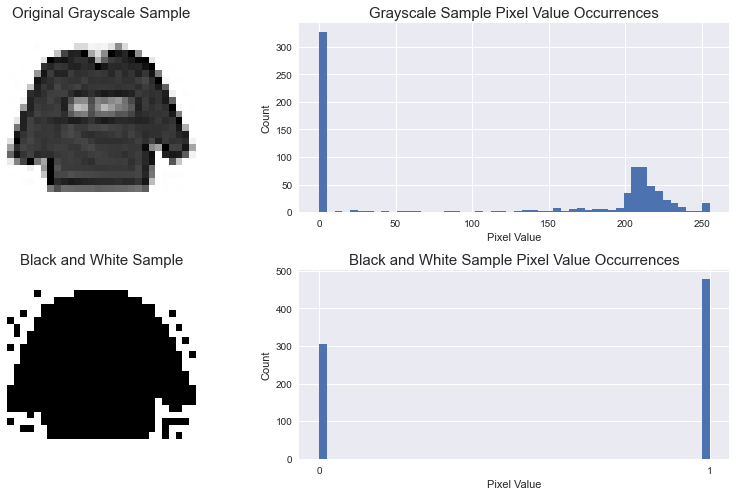

In [15]:
# sample image
some_sample = fmnist.drop('label', axis=1).iloc[0]  # get sample
some_sample = np.array(some_sample)  # convert to array
some_sample_img = some_sample.reshape(28, 28)  # reshape array

# convert sample image from grayscale to black and white
# in the fashion mnist dataset white pixels are 0 and black pixels are 255
# the images are grayscale, so values (0,255) are different intensities of gray
some_sample_bin = some_sample.copy()  # deep copy of the sample image
some_sample_bin[some_sample_bin > 0] = 1  # convert gray intensities to black
some_sample_bin_img = some_sample_bin.reshape(28, 28)  # reshape array

fig, dx = plt.subplots(2, 2, figsize=(12, 7))

# plot grayscale sample image and pixel value occurrences
dx[0, 0].imshow(some_sample_img)
dx[0, 0].axis('off')
dx[0, 0].set_title("Original Grayscale Sample", size=15)
dx[0, 1].hist(some_sample, bins=50)
dx[0, 1].set_title("Grayscale Sample Pixel Value Occurrences", size=15)
dx[0, 1].set_xlabel("Pixel Value")
dx[0, 1].set_ylabel("Count")
# plot black and white sample image and pixel value occurrences
dx[1, 0].imshow(some_sample_bin_img)
dx[1, 0].axis('off')
dx[1, 0].set_title("Black and White Sample", size=15)
dx[1, 1].hist(some_sample_bin, bins=50)
dx[1, 1].set_title("Black and White Sample Pixel Value Occurrences", size=15)
dx[1, 1].set_xticks([0, 1])
dx[1, 1].set_xlabel("Pixel Value")
dx[1, 1].set_ylabel("Count")
plt.tight_layout()
plt.show()

> #### Observations:
> * The most common pixel value in the original grayscale image is white (0) and in the binary
image is black (1).
* Aside from a few pixels that are detached from the clothing, the black and white pullover resembles
the original grayscale shape.
* Training models on both options and comparing the results can help determine if transforming the
images to black and white improves performance.

> ### Class Comparison

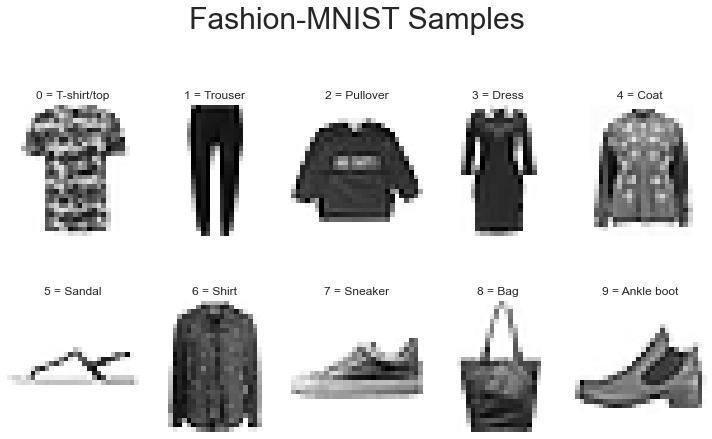

In [16]:
# plot image for each category

# use of a dictionary to easily add subplot titles
label_dict = {0: "0 = T-shirt/top", 1: "1 = Trouser", 2: "2 = Pullover", 3: "3 = Dress", 4: "4 = Coat",
              5: "5 = Sandal", 6: "6 = Shirt", 7: "7 = Sneaker", 8: "8 = Bag", 9: "9 = Ankle boot"}

fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 5
# use groupby to locate an instance for each label
label_groups = fmnist.groupby('label')
# add image in each iteration
for i in range(rows * columns):
    curr = label_groups.get_group(i)[:1]  # get group
    curr_img = curr.drop('label', axis=1).to_numpy().reshape(28, 28)  # convert to reshaped array
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(curr_img)
    plt.axis('off')  # remove grid
    plt.title(label_dict[i])  # use dictionary to add subplot title

fig.suptitle("Fashion-MNIST Samples", size=30)
plt.tight_layout()
plt.show()

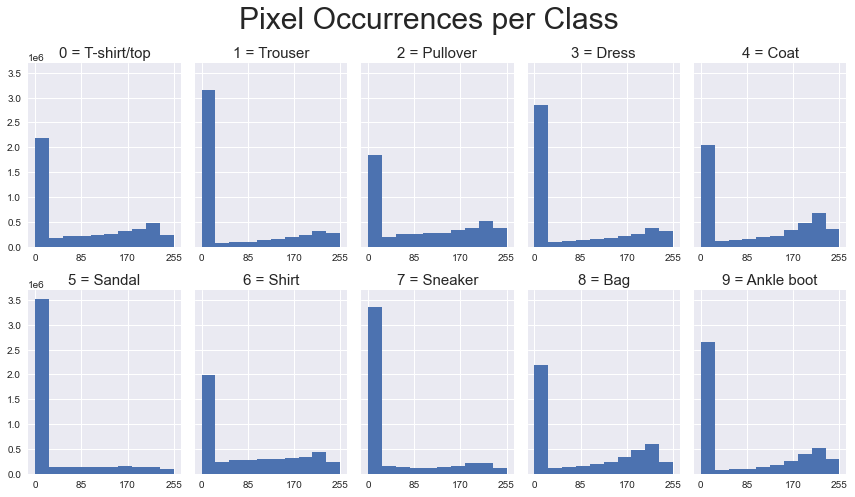

In [17]:
# plot pixel value occurrences for each class

fig, dx = plt.subplots(2, 5, figsize=(12, 7), sharey='all')
i = 0  # current group label
mean_values = []
plt.setp(dx, xticks=np.arange(0, 256, step=85))  # set x axis values

for row in range(2):
    for col in range(5):
        pixels = np.array(label_groups.get_group(i).drop(['label'], axis=1))  # get group and convert to array
        mean_values.append(pixels.mean())  # calculate mean pixel value and add to list (for next plot)
        dx[row, col].hist(pixels.reshape(-1))  # add histogram in each iteration, -1 reshapes to length of array
        dx[row, col].set_title(label_dict[i], size=15)  # use dictionary to add subplot title
        i = i + 1  # next group

fig.suptitle("Pixel Occurrences per Class", size=30)
plt.tight_layout()
plt.show()

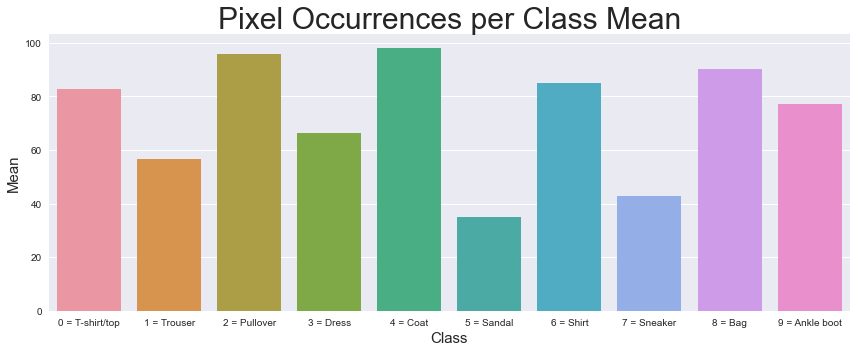

In [18]:
# plot mean values calculated in previous cell
plt.figure(figsize=(12, 5))
sns.barplot(x=np.arange(10), y=mean_values)  # x axis for classes, y axis for mean values
plt.xticks(np.arange(10), labels=label_dict.values())  # use dictionary to set x axis values
plt.xlabel("Class", size=15)
plt.ylabel("Mean", size=15)
plt.title("Pixel Occurrences per Class Mean", size=30)
plt.tight_layout()
plt.show()

> #### Observations:
* All classes have a majority of white pixel values (0), with the remaining scattered in the rest of the range.
* Aside from the white pixel value, quite a few of the histograms displaying pixel occurrences look like
they have a somewhat normal distribution. They are tail-heavy, extending farther to the left of the
median.
* Any shoe type (classes 5, 7, 9) have the most white pixels, with sandal (class 5) containing the most.
This is emphasized most in the pixel occurrences mean plot.
* Coats (class 4) and pullovers (class 2) have the highest pixel mean. When looking at the sample
images it is noticeable that they fill most of the diagram.
* The t-shirt/top (class 0) and shirt (class 6) have extremely similar pixel occurrences.
Had the class labels been removed, the graphs would be indistinguishable. It is likely that
the models will make mistakes when predicting instances from these two classes!

> ### Analyze and Compare Sample Images of T-shirt/top and Shirt Classes

In [19]:
# t-shirt/top sample image (class 0)
top = label_groups.get_group(0).drop('label', axis=1).iloc[0]  # get t-shirt/top sample
top = np.array(top)  # convert to array
top_img = top.reshape(28, 28)  # reshape array

# convert t-shirt/top sample image from grayscale to black and white
top_bin = top.copy()  # deep copy of the t-shirt/top sample image
top_bin[top_bin > 0] = 1  # convert gray intensities to black
top_bin_img = top_bin.reshape(28, 28)  # reshape array

# shirt sample image (class 6)
shirt = label_groups.get_group(6).drop('label', axis=1).iloc[0]  # get t-shirt/top sample
shirt = np.array(shirt)  # convert to array
shirt_img = shirt.reshape(28, 28)  # reshape array

# convert shirt sample image from grayscale to black and white
shirt_bin = shirt.copy()  # deep copy of the shirt sample image
shirt_bin[shirt_bin > 0] = 1  # convert gray intensities to black
shirt_bin_img = shirt_bin.reshape(28, 28)  # reshape array

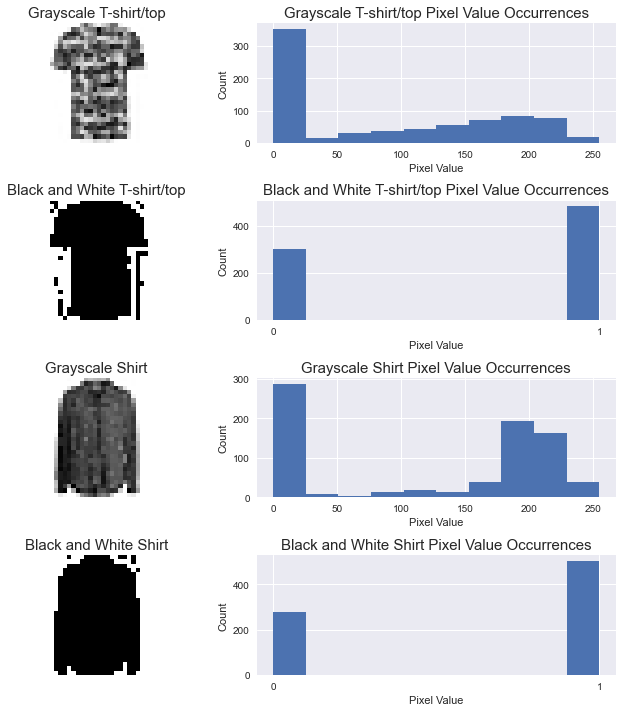

In [20]:
fig, dx = plt.subplots(4, 2, figsize=(10, 10))

# plot grayscale t-shirt/top sample image and pixel value occurrences
dx[0, 0].imshow(top_img)
dx[0, 0].axis('off')
dx[0, 0].set_title("Grayscale T-shirt/top", size=15)
dx[0, 1].hist(top)
dx[0, 1].set_title("Grayscale T-shirt/top Pixel Value Occurrences", size=15)
dx[0, 1].set_xlabel("Pixel Value")
dx[0, 1].set_ylabel("Count")
# plot black and white t-shirt/top sample image and pixel value occurrences
dx[1, 0].imshow(top_bin_img)
dx[1, 0].axis('off')
dx[1, 0].set_title("Black and White T-shirt/top", size=15)
dx[1, 1].hist(top_bin)
dx[1, 1].set_title("Black and White T-shirt/top Pixel Value Occurrences", size=15)
dx[1, 1].set_xticks([0, 1])
dx[1, 1].set_xlabel("Pixel Value")
dx[1, 1].set_ylabel("Count")

# plot grayscale shirt sample image and pixel value occurrences
dx[2, 0].imshow(shirt_img)
dx[2, 0].axis('off')
dx[2, 0].set_title("Grayscale Shirt", size=15)
dx[2, 1].hist(shirt)
dx[2, 1].set_title("Grayscale Shirt Pixel Value Occurrences", size=15)
dx[2, 1].set_xlabel("Pixel Value")
dx[2, 1].set_ylabel("Count")
# plot black and white shirt sample image and pixel value occurrences
dx[3, 0].imshow(shirt_bin_img)
dx[3, 0].axis('off')
dx[3, 0].set_title("Black and White Shirt", size=15)
dx[3, 1].hist(shirt_bin)
dx[3, 1].set_title("Black and White Shirt Pixel Value Occurrences", size=15)
dx[3, 1].set_xticks([0, 1])
dx[3, 1].set_xlabel("Pixel Value")
dx[3, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

> #### Observations:
* The main difference between the classes are the pixels representing the sleeves.
The t-shirt/top has short sleeves and the shirt has long sleeves.
* Converting the images to binary shows where the mix-up between the classes might be.
The t-shirt has gray pixels that aren't seen in the grayscale image, but stand out in the
black and white image. The unseen gray pixels appear where the long sleeves would be
had this been a shirt.
* The pixel value occurrences are similar when comparing the black and white images and are
spread out differently in the grayscale images.

# 3. Data Cleaning

In [21]:
# clean copy of the training set
df = train_set.copy()

In [22]:
# separate features from target values

# drop- creates a copy without changing the training set
X_train = df.drop('label', axis=1)

# create a deep copy of the target values
y_train = df['label'].copy()

> ### Custom Transformer:
> In section 2, I evaluated samples in grayscale and in black and white.
> I assumed that converting images to black and white could improve the ML algorithms.
>
> The following custom transformer automates this process on the entire dataset:
>
>> The ColorConverter transformer contains the hyperparameter "is_binary". It is
> set by default to 'False', meaning the samples remain in the original grayscale format.
> However, the hyperparameter can be set to 'True' which will convert the images to black
> and white.
>>
>> Adding this transformer will allow to easily switch between the two options during
> model training, and determine which one is better.

In [23]:
# custom transformer for converting images to black and white
# default is set to leave as original grayscale images
# when is_binary hyperparameter is set to True data is converted to binary

# BaseEstimator for enabling hyperparameters
# TransformerMixin adds fit_transform method
class ColorConverter(BaseEstimator, TransformerMixin):

    def __init__(self, is_binary=False):
        self.is_binary = is_binary

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.is_binary:
            X_binary = X.copy()
            X_binary[X_binary > 0] = 1
            return X_binary
        else:
            return X

> ### Feature Scaling
>
> Although the pixel values are in a known range [0,255], scaling the data can make a crucial difference
(especially if the learning algorithm relies on calculating distances).
>
>> Why is this important?
* Models can't differentiate feature importance the same way humans can.
A training algorithm may assume that a feature containing large numbers is more important than features
with smaller numbers- which might not be the case.
* Some algorithms converge much faster when features are scaled (i.e. Gradient Descent).
* There are ML algorithms that make assumptions on the data (i.e. PCA assumes the data is centered around
the origin).


> Chosen feature scale:
>
> Standardizing centers the data so that it has a zero mean and a standard deviation of 1, under the assumption
> that the data is normally distributed.
>
> * The distribution is relatively normal (aside from the white pixels which is highest for all classes).
* Using PCA could be useful since the dataset has a large amount of features. As previously stated,
PCA assumes the data has zero mean.
>
> Therefore, standard scaling is the ideal option.

In [24]:
# create transformation pipeline

# How to change ColorConverter is_binary hyperparameter:
# full_pipeline['clr_convert'].__setattr__('is_binary', True)


full_pipeline = Pipeline([
    ('clr_convert', ColorConverter()),
    ('std_scaler', StandardScaler()),
])

In [25]:
# transform training data using pipeline
X_train_prepared = full_pipeline.fit_transform(X_train)

# 4. Training and Evaluating Models

> The number of instances for each class in the training set are equal which makes this
> a balanced classification task.
>
> Chosen evaluation metric:
>
> Accuracy works well with balanced classification tasks. It is also the most intuitive
> metric and is especially easier to understand when dealing with multiclass classification.
>> Note:
* Accuracy is sensitive to the test size. Therefore, I will use 6 cross-validation folds
(total of 10,000 instances in each test fold).
* Since the features consist of pixel values, it is likely that the testing data would fit the
transformers nearly the same. This means that cross-validation should give good assessment
of the performance on unseen data, even when evaluating only the fitted and transformed training data.

In [26]:
# function for evaluating cross validation scores and for easy model comparison
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", round(scores.mean(), 5))
    print("Standard Deviation:", round(scores.std(), 5))


# function prints accuracy and errors
def display_evaluation(actual, pred):
    print("Accuracy:", round(metrics.accuracy_score(actual, pred),5))
    print("Display Errors in Confusion Matrix:")
    conf_mx = metrics.confusion_matrix(actual, pred, labels=range(10))
    row_sums = conf_mx.sum(axis=1, keepdims=True)
    norm_conf_mx = conf_mx / row_sums
    np.fill_diagonal(norm_conf_mx, 0)
    plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
    plt.grid(False)
    plt.show()

### Shortlist Promising Models:
> Trying many models quickly and selecting the ones that show promising results.
>
>> How I plan to do this:
1. Train a baseline model and evaluate sample predictions.
**Continue to step 2 if the sample predictions were mostly correct.**
2. Use cross-validation and evaluate scores.
3. If the model has a significant hyperparameters, try changing it. Use cross-validation to
compare the results to step 2.

In [27]:
# a few instances from the training data for testing
some_data = X_train.iloc[:10]
some_labels = y_train.iloc[:10]
some_data_prepared = full_pipeline.transform(some_data)

#### 1. Logistic Regression

In [28]:
# multinomial = softmax regression, used for multiclass
# softmax normalizes so that the total probability sum is 1
log_reg = LogisticRegression(multi_class='multinomial', random_state=42, n_jobs=-1)
# log_reg.fit(X_train_prepared, y_train)
# joblib.dump(log_reg, "FMNIST/models/log_reg_1.pkl")
log_reg = joblib.load(r"FMNIST/models/log_reg_1.pkl")

print("Predictions:", log_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [2 9 6 0 3 6 4 5 4 8]
Labels: [2, 9, 6, 0, 3, 4, 4, 5, 4, 8]


In [29]:
# log_reg_scores_1 = cross_val_score(log_reg, X_train_prepared, y_train, scoring='accuracy', cv=6)
# joblib.dump(log_reg_scores_1, "FMNIST/scores/log_reg_scores_1.pkl")
log_reg_scores_1 = joblib.load(r"FMNIST/scores/log_reg_scores_1.pkl")
display_scores(log_reg_scores_1)

Scores: [0.8562 0.8508 0.8535 0.8499 0.8482 0.8501]
Mean: 0.85145
Standard Deviation: 0.00264


#### 2. KNN

In [30]:
# using default weights (uniform)
# using default n_neighbors (n = 5)
knn_clf = KNeighborsClassifier(n_jobs=-1)
# knn_clf.fit(X_train_prepared, y_train)
# joblib.dump(knn_clf, "FMNIST/models/knn_clf_2.pkl")
knn_clf = joblib.load(r"FMNIST/models/knn_clf_2.pkl")

print("Predictions:", knn_clf.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [2 9 6 0 3 4 4 5 4 8]
Labels: [2, 9, 6, 0, 3, 4, 4, 5, 4, 8]


In [31]:
# knn_scores_2 = cross_val_score(knn_clf, X_train_prepared, y_train, scoring='accuracy', cv=6)
# joblib.dump(knn_scores_2, "FMNIST/scores/knn_scores_2.pkl")
knn_scores_2 = joblib.load(r"FMNIST/scores/knn_scores_2.pkl")
display_scores(knn_scores_2)

Scores: [0.8592 0.8537 0.853  0.857  0.8522 0.8528]
Mean: 0.85465
Standard Deviation: 0.00256


#### 3. Decision Tree Classifier

In [32]:
tree_clf = DecisionTreeClassifier(random_state=42)
# tree_clf.fit(X_train_prepared, y_train)
# joblib.dump(tree_clf, "FMNIST/models/tree_clf_3.pkl")
tree_clf = joblib.load(r"FMNIST/models/tree_clf_3.pkl")

print("Predictions:", tree_clf.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [2 9 6 0 3 4 4 5 4 8]
Labels: [2, 9, 6, 0, 3, 4, 4, 5, 4, 8]


In [33]:
# tree_scores_3 = cross_val_score(tree_clf, X_train_prepared, y_train, scoring='accuracy', cv=6, n_jobs=-1)
# joblib.dump(tree_scores_3, "FMNIST/scores/tree_scores_3.pkl")
tree_scores_3 = joblib.load(r"FMNIST/scores/tree_scores_3.pkl")
display_scores(tree_scores_3)

Scores: [0.791  0.7946 0.7932 0.7989 0.7962 0.7939]
Mean: 0.79463
Standard Deviation: 0.00246


#### 4. Random Forest Classifier

In [34]:
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
# rf_clf.fit(X_train_prepared, y_train)
# joblib.dump(rf_clf, "FMNIST/models/rf_clf_4.pkl")
rf_clf = joblib.load(r"FMNIST/models/rf_clf_4.pkl")

print("Predictions:", rf_clf.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [2 9 6 0 3 4 4 5 4 8]
Labels: [2, 9, 6, 0, 3, 4, 4, 5, 4, 8]


In [35]:
# rf_scores_4 = cross_val_score(rf_clf, X_train_prepared, y_train, scoring='accuracy', cv=6)
# joblib.dump(rf_scores_4, "FMNIST/scores/rf_scores_4.pkl")
rf_scores_4 = joblib.load(r"FMNIST/scores/rf_scores_4.pkl")
display_scores(rf_scores_4)

Scores: [0.8844 0.8805 0.8854 0.8812 0.8776 0.8815]
Mean: 0.88177
Standard Deviation: 0.00257


Before continuing, I will try these 4 models again on the black and white dataset.

In [36]:
full_pipeline['clr_convert'].__setattr__('is_binary', True)
full_pipeline.steps[0]

('clr_convert', ColorConverter(is_binary=True))

In [37]:
# transform training data using pipeline
X_train_prepared2 = full_pipeline.fit_transform(X_train)

# a few instances from the training data for testing
some_data_prepared2 = full_pipeline.transform(some_data)

> Note: Fitting the same model will overwrite the previous fit.

#### 5. Logistic Regression

In [38]:
# log_reg.fit(X_train_prepared2, y_train)
# joblib.dump(log_reg, "FMNIST/models/log_reg_5.pkl")
log_reg = joblib.load(r"FMNIST/models/log_reg_5.pkl")

print("Predictions:", log_reg.predict(some_data_prepared2))
print("Labels:", list(some_labels))

Predictions: [6 9 6 0 3 6 4 5 4 8]
Labels: [2, 9, 6, 0, 3, 4, 4, 5, 4, 8]


In [39]:
# log_reg_scores_5 = cross_val_score(log_reg, X_train_prepared2, y_train, scoring='accuracy', cv=6)
# joblib.dump(log_reg_scores_5, "FMNIST/scores/log_reg_scores_5.pkl")
log_reg_scores_5 = joblib.load(r"FMNIST/scores/log_reg_scores_5.pkl")
display_scores(log_reg_scores_5)

Scores: [0.8464 0.8427 0.845  0.8391 0.8417 0.8388]
Mean: 0.84228
Standard Deviation: 0.0028


#### 6. KNN

In [40]:
# knn_clf.fit(X_train_prepared2, y_train)
# joblib.dump(knn_clf, "FMNIST/models/knn_clf_6.pkl")
knn_clf = joblib.load(r"FMNIST/models/knn_clf_6.pkl")

print("Predictions:", knn_clf.predict(some_data_prepared2))
print("Labels:", list(some_labels))

Predictions: [2 9 6 0 3 6 4 5 4 8]
Labels: [2, 9, 6, 0, 3, 4, 4, 5, 4, 8]


In [41]:
# knn_scores_6 = cross_val_score(knn_clf, X_train_prepared2, y_train, scoring='accuracy', cv=6)
# joblib.dump(knn_scores_6, "FMNIST/scores/knn_scores_6.pkl")
knn_scores_6 = joblib.load(r"FMNIST/scores/knn_scores_6.pkl")
display_scores(knn_scores_6)

Scores: [0.8404 0.8347 0.839  0.836  0.8359 0.8432]
Mean: 0.8382
Standard Deviation: 0.00297


#### 7. Decision Tree Classifier

In [42]:
# tree_clf.fit(X_train_prepared2, y_train)
# joblib.dump(tree_clf, "FMNIST/models/tree_clf_7.pkl")
tree_clf = joblib.load(r"FMNIST/models/tree_clf_7.pkl")

print("Predictions:", tree_clf.predict(some_data_prepared2))
print("Labels:", list(some_labels))

Predictions: [2 9 6 0 3 4 4 5 4 8]
Labels: [2, 9, 6, 0, 3, 4, 4, 5, 4, 8]


In [43]:
# tree_scores_7 = cross_val_score(tree_clf, X_train_prepared2, y_train, scoring='accuracy', cv=6, n_jobs=-1)
# joblib.dump(tree_scores_7, "FMNIST/scores/tree_scores_7.pkl")
tree_scores_7 = joblib.load(r"FMNIST/scores/tree_scores_7.pkl")
display_scores(tree_scores_7)

Scores: [0.7935 0.787  0.7935 0.7956 0.7874 0.7887]
Mean: 0.79095
Standard Deviation: 0.00336


#### 8. Random Forest Classifier

In [45]:
# rf_clf.fit(X_train_prepared2, y_train)
# joblib.dump(rf_clf, "FMNIST/models/rf_clf_8.pkl")
rf_clf = joblib.load(r"FMNIST/models/rf_clf_8.pkl")

print("Predictions:", rf_clf.predict(some_data_prepared2))
print("Labels:", list(some_labels))

Predictions: [2 9 6 0 3 4 4 5 4 8]
Labels: [2, 9, 6, 0, 3, 4, 4, 5, 4, 8]


In [46]:
# rf_scores_8 = cross_val_score(rf_clf, X_train_prepared2, y_train, scoring='accuracy', cv=6)
# joblib.dump(rf_scores_8, "FMNIST/scores/rf_scores_8.pkl")
rf_scores_8 = joblib.load(r"FMNIST/scores/rf_scores_8.pkl")
display_scores(rf_scores_8)

Scores: [0.8801 0.8794 0.8785 0.8792 0.8779 0.8787]
Mean: 0.87897
Standard Deviation: 0.0007


All models performed slightly worse after converting the images to black and white, the mean after cross-validation
was lower.

When looking at the feature importance from the random forest classifier, it seems that some pixels are
redundant around the corners and edges and others towards the middle are very important.

PCA is a dimensionality technique that ...

Evaluating the models on both grayscale and black and white images was a vital step. While PCA does improve
training computation time, some data is lost, so it is better to choose the transformation that has better results.

Therefore, I will use the grayscale images for PCA.

In [47]:
# change hyperparameter for grayscale images
full_pipeline['clr_convert'].__setattr__('is_binary', False)
full_pipeline.steps[0]  # check that the hyperparameter changed

('clr_convert', ColorConverter())

In [48]:
pca = PCA()
pca.fit(X_train_prepared)
# cumulative sum (increasing by sequential addition) of components
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

256

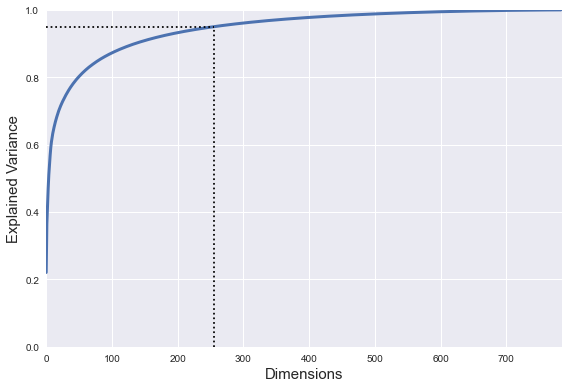

In [49]:
plt.axis([0, 784, 0, 1])  # axis limits
plt.plot(cumsum, linewidth=3)
plt.xlabel("Dimensions", size=15)
plt.ylabel("Explained Variance", size=15)
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.tight_layout()
plt.show()

> Using the elbow method, around 95% explained variance is where the graph starts growing slower.
>
> For instance, reducing the dimensions from 784 down to 256 will preserve 95% of the variance with only
> a little data loss.
>
> I will use cross-validation on the transformed data in the range of 90-95 percent explained variance
> to determine which is the optimal choice.
>
>>  Note: PCA is being used as a pre-processing step, so the model score can be used to evaluate performance.

#### 10. Logistic Regression

> Before PCA:

In [50]:
display_scores(log_reg_scores_1)

Scores: [0.8562 0.8508 0.8535 0.8499 0.8482 0.8501]
Mean: 0.85145
Standard Deviation: 0.00264


> After PCA:

In [51]:
pca_log_reg = Pipeline([
    ("pca", PCA()),
    ("log_reg", LogisticRegression(multi_class='multinomial', random_state=42))
])

param_grid = [{
    "pca__n_components": [0.9, 0.91, 0.92, 0.93, 0.94, 0.95]
}]

In [52]:
# pca_log_reg_grid = GridSearchCV(pca_log_reg, param_grid, cv=6, scoring="accuracy", verbose=2, n_jobs=-1)
# pca_log_reg_grid.fit(X_train_prepared, y_train)
# joblib.dump(pca_log_reg_grid, "FMNIST/scores/pca_log_reg_grid.pkl")
pca_log_reg_grid = joblib.load(r"FMNIST/scores/pca_log_reg_grid.pkl")

In [53]:
pca_log_reg_grid.best_params_

{'pca__n_components': 0.95}

In [54]:
pca_log_reg_grid.best_score_

0.8529666666666667

In [55]:
# show results for each iteration
cvres = pca_log_reg_grid.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.84915 {'pca__n_components': 0.9}
0.8501833333333333 {'pca__n_components': 0.91}
0.8508999999999999 {'pca__n_components': 0.92}
0.8514666666666666 {'pca__n_components': 0.93}
0.8516333333333334 {'pca__n_components': 0.94}
0.8529666666666667 {'pca__n_components': 0.95}


#### 11. Random Forest

> Random Forest before PCA:

In [56]:
display_scores(rf_scores_4)

Scores: [0.8844 0.8805 0.8854 0.8812 0.8776 0.8815]
Mean: 0.88177
Standard Deviation: 0.00257


> Random Forest after PCA:

In [57]:
pca_rf_clf = Pipeline([
    ("pca", PCA()),
    ("rf_clf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

In [58]:
# pca_rf_clf_grid = GridSearchCV(pca_rf_clf, param_grid, cv=6, scoring="accuracy", verbose=2)
# pca_rf_clf_grid.fit(X_train_prepared, y_train)
# joblib.dump(pca_rf_clf_grid, "FMNIST/scores/pca_rf_clf_grid.pkl")
pca_rf_clf_grid = joblib.load(r"FMNIST/scores/pca_rf_clf_grid.pkl")

In [59]:
pca_rf_clf_grid.best_params_

{'pca__n_components': 0.92}

In [60]:
pca_rf_clf_grid.best_score_

0.8665166666666666

In [61]:
# show results for each iteration
cvres = pca_rf_clf_grid.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.8659 {'pca__n_components': 0.9}
0.8653166666666667 {'pca__n_components': 0.91}
0.8665166666666666 {'pca__n_components': 0.92}
0.8648333333333333 {'pca__n_components': 0.93}
0.8636666666666667 {'pca__n_components': 0.94}
0.8622500000000001 {'pca__n_components': 0.95}


> #### Observations:
* Logistic Regression had the highest score with 0.95 explained variance, slightly higher than before PCA.
* Random Forest had the highest score with 0.92 explained variance, the score is roughly 2% lower than before PCA.
* The Random Forest scores were all nearly the same. Meanwhile, the Logistic Regression scores show a downward trend.
Choosing 0.91 explained variance seems like a reasonable ratio that preserves data and model accuracy.

In [62]:
d = np.argmax(cumsum >= 0.91) + 1
d

153

> PCA reduces the dimensions from 784 to 153!

In [63]:
# add PCA to pipeline
full_pipeline.steps.append(('pca', PCA(n_components=0.91)))
full_pipeline

Pipeline(steps=[('clr_convert', ColorConverter()),
                ('std_scaler', StandardScaler()),
                ('pca', PCA(n_components=0.91))])

In [64]:
# transform data with reduced dimensions
X_train_reduced = full_pipeline.fit_transform(X_train, y_train)
some_data_reduced = full_pipeline.transform(some_data)

#### 12. KNN

In [65]:
# knn_scores_12 = cross_val_score(clone(knn_clf), X_train_reduced, y_train, cv=6, scoring='accuracy', verbose=2)
# joblib.dump(knn_scores_12, "FMNIST/scores/knn_scores_12.pkl")
knn_scores_12 = joblib.load(r"FMNIST/scores/knn_scores_12.pkl")
display_scores(knn_scores_12)

Scores: [0.8642 0.8641 0.8612 0.8629 0.8641 0.8595]
Mean: 0.86267
Standard Deviation: 0.00177


#### 13. Decision Tree

In [66]:
# tree_scores_13 = cross_val_score(clone(tree_clf), X_train_reduced, y_train, cv=6, scoring='accuracy', n_jobs=-1, verbose=2)
# joblib.dump(tree_scores_13, "FMNIST/scores/tree_scores_13.pkl")
tree_scores_13 = joblib.load(r"FMNIST/scores/tree_scores_13.pkl")
display_scores(tree_scores_13)

Scores: [0.7732 0.7696 0.7677 0.7671 0.7661 0.7608]
Mean: 0.76742
Standard Deviation: 0.00374


#### 14. Extra Trees Classifier
> Very similar to the Random Forest classifier. The main difference is that Extra Trees randomly splits
> nodes, while Random Forest searches for the best split. Extra Trees is also faster to train due to this.
>> Note: Comparing prediction accuracy can help determine which model performs better on the data.

In [67]:
ex_trees = ExtraTreesClassifier(random_state=42, n_jobs=-1)
# ex_trees.fit(X_train_reduced, y_train)
# joblib.dump(ex_trees, "FMNIST/models/ex_trees.pkl")
ex_trees = joblib.load(r"FMNIST/models/ex_trees.pkl")

print("Predictions:", ex_trees.predict(some_data_reduced))
print("Labels:", list(some_labels))

Predictions: [2 9 6 0 3 4 4 5 4 8]
Labels: [2, 9, 6, 0, 3, 4, 4, 5, 4, 8]


In [68]:
# ex_trees_scores_14 = cross_val_score(ex_trees, X_train_reduced, y_train, cv=6, scoring='accuracy', verbose=2)
# joblib.dump(ex_trees_scores_14, "FMNIST/scores/ex_trees_scores_14.pkl")
ex_trees_scores_14 = joblib.load(r"FMNIST/scores/ex_trees_scores_14.pkl")
display_scores(ex_trees_scores_14)

Scores: [0.8672 0.8663 0.8679 0.8686 0.8667 0.8634]
Mean: 0.86668
Standard Deviation: 0.00165


> Comparing Extra Trees to Random Forest:

In [69]:
# rf_clf_scores_14 = cross_val_score(clone(rf_clf), X_train_reduced, y_train, cv=6, scoring='accuracy', verbose=2)
# joblib.dump(rf_clf_scores_14, "FMNIST/scores/rf_clf_scores_14.pkl")
rf_clf_scores_14 = joblib.load(r"FMNIST/scores/rf_clf_scores_14.pkl")
display_scores(rf_clf_scores_14)

Scores: [0.8673 0.8637 0.87   0.8666 0.8628 0.8651]
Mean: 0.86592
Standard Deviation: 0.00239


> Extra Trees has a higher accuracy and a lower standard deviation, making it more reliable.

#### 15. AdaBoost
> The AdaBoost (adaptive boosting) ensemble method trains a weak classifier, then increases the
> weights of the misclassified instances and trains another weak classifier on the dataset with the
> updated weights.
>> Note: The sklearn default algorithm ("SAMME.R") is multiclass. SAMME.R uses class probabilities
>> and SAMME uses the predicted classes.

In [70]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(), random_state=42)
# ada_clf.fit(X_train_reduced, y_train)
# joblib.dump(ada_clf, "FMNIST/models/ada_clf_15.pkl")
ada_clf = joblib.load(r"FMNIST/models/ada_clf_15.pkl")

print("Predictions:", ada_clf.predict(some_data_reduced))
print("Labels:", list(some_labels))

Predictions: [2 9 6 0 3 4 4 5 4 8]
Labels: [2, 9, 6, 0, 3, 4, 4, 5, 4, 8]


In [71]:
# ada_scores_15 = cross_val_score(ada_clf, X_train_reduced, y_train, cv=6, scoring='accuracy', n_jobs=-1, verbose=2)
# joblib.dump(ada_scores_15, "FMNIST/scores/ada_scores_15.pkl")
ada_scores_15 = joblib.load(r"FMNIST/scores/ada_scores_15.pkl")
display_scores(ada_scores_15)

Scores: [0.7726 0.7668 0.7652 0.771  0.7664 0.7637]
Mean: 0.76762
Standard Deviation: 0.00315


#### 16. XGBoost
> The Gradient Boosting ensemble method that fits a new weak classifier to the errors
> made by the previous classifiers, then makes predictions on the combined classifiers.
>> Note: XGBoost (extreme gradient boosting) is a separate library from sklearn
> that contains an optimized version of gradient boosting.

In [72]:
# xgb_clf = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='merror', objective='multi:softmax',
#                        num_class=10, use_label_encoder=False)
# xgb_clf.fit(X_train_reduced, y_train)
# joblib.dump(xgb_clf, "FMNIST/models/xgb_clf_16.pkl")
xgb_clf = joblib.load(r"FMNIST/models/xgb_clf_16.pkl")

print("Predictions:", xgb_clf.predict(some_data_reduced))
print("Labels:", list(some_labels))

Predictions: [2 9 6 0 3 4 4 5 4 8]
Labels: [2, 9, 6, 0, 3, 4, 4, 5, 4, 8]


In [73]:
xgb_clf.best_iteration

99

In [74]:
params = {
    "objective": "multi:softmax",
    "num_class": 10,
    "eval_metric": "merror" # merror is 1-accuracy, the m stands for multiclass
}

# dmatrix is a data structure used by the XGBoost library that optimizes performance
# it is needed when using the XGBoost library cross-validation
dmat_train = DMatrix(X_train_reduced, y_train)

In [75]:
# xgb_scores_16 = cv(params, dmat_train, num_boost_round=100, nfold=6,
#                   early_stopping_rounds=5, seed=42, metrics="merror", verbose_eval=True)
# joblib.dump(xgb_scores_16, "FMNIST/scores/xgb_scores_16.pkl")
xgb_scores_16 = joblib.load(r"FMNIST/scores/xgb_scores_16.pkl")

In [76]:
curr_min = xgb_scores_16["test-merror-mean"].argmin()
curr_min

99

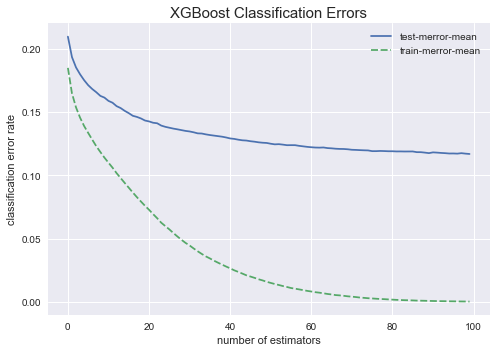

In [77]:
# plot classification errors from cross-validation
plt.figure(figsize=(7, 5))
sns.lineplot(data=[xgb_scores_16["test-merror-mean"], xgb_scores_16["train-merror-mean"]])
plt.xlabel("number of estimators")
plt.ylabel("classification error rate")
plt.title("XGBoost Classification Errors", size=15)
plt.tight_layout()
plt.show()

In [78]:
# best accuracy
1 - xgb_scores_16["test-merror-mean"][curr_min]

0.8831333333333333

> So far, the minimum errors are with 100. The errors only decreased, so during hyperparameter
tuning larger parameters should be tested.

> #### Observations:
* The best models (from lowest to highest scores): Logistic Regression, KNN, Extra Trees and XGBoost.
* Decision Tree and AdaBoost models had the lowest performance, both below 80% accuracy.

> ### Looking back:
>
> The best pre-processing steps and baseline models have been determined.
> The next step is to find the best hyperparameters for the models using Grid Search or Randomized Search.

#### Fine-Tune Logistic Regression

Accuracy: 0.85042
Display Errors in Confusion Matrix:


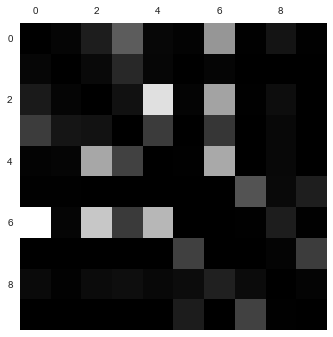

In [79]:
# predict accuracy and plot errors before tuning

# log_reg_pred = cross_val_predict(log_reg, X_train_reduced, y_train, cv=6, verbose=2, n_jobs=-1)
# joblib.dump(log_reg_pred, "FMNIST/pred/ log_reg_pred.pkl")
log_reg_pred = joblib.load(r"FMNIST/pred/ log_reg_pred.pkl")
display_evaluation(y_train, log_reg_pred)

> * When the Logistic Regression parameter 'multi_class' is set to 'multinomial', it is using Softmax Regression
which is optimized for multi-class inputs. Simply put, it estimates the probability that an instance belongs
to each class and predicts the highest one. The sum of all probabilities estimated is equal to 1.
* Another approach: One-vs-One and One-vs-Rest wrapper methods.
>
> I'll search for the best hyperparameters, then try applying the best estimator with the wrapper methods.

> Tuning solver and penalty:

In [80]:
# both sag and saga solvers work well with large datasets and multiclass
# they are a variation of gradient descent
# convergence is faster when the data is scaled

param_grid = [{
     "solver": ["sag", "saga"] # sag = stochastic average gradient, saga = variant of sag solver
}]

In [81]:
# log_reg = LogisticRegression(multi_class='multinomial', random_state=42)
# log_reg_cv = GridSearchCV(log_reg, param_grid, cv=6, scoring='accuracy', n_jobs=-1, verbose=2)
# log_reg_cv.fit(X_train_reduced, y_train)
# joblib.dump(log_reg_cv, "FMNIST/scores/log_reg_cv.pkl") # save local copy
log_reg_cv = joblib.load(r"FMNIST/scores/log_reg_cv.pkl")

In [82]:
# show the best score
log_reg_cv.best_score_

0.8497166666666667

In [83]:
# best estimator
log_reg2 = log_reg_cv.best_estimator_
log_reg2

LogisticRegression(multi_class='multinomial', random_state=42, solver='sag')

In [84]:
# show results for each iteration
cvres = log_reg_cv.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.8497166666666667 {'solver': 'sag'}
0.8479666666666666 {'solver': 'saga'}


In [85]:
param_grid = [{
    "C": [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]  # C controls regularization,
    # light penalty if close to 1.0, strong penalty if close to 0.0
}]

In [86]:
# log_reg_cv2 = GridSearchCV(log_reg2, param_grid, cv=6, scoring='accuracy', n_jobs=-1, verbose=2)
# log_reg_cv2.fit(X_train_reduced, y_train)
# joblib.dump(log_reg_cv2, "FMNIST/scores/log_reg_cv2.pkl")
log_reg_cv2 = joblib.load(r"FMNIST/scores/log_reg_cv2.pkl")

In [87]:
# show the best score
log_reg_cv2.best_score_

0.8497666666666667

In [88]:
# best estimator
log_reg3 = log_reg_cv2.best_estimator_
log_reg3

LogisticRegression(C=0.5, multi_class='multinomial', random_state=42,
                   solver='sag')

In [89]:
# show results for each iteration
cvres = log_reg_cv2.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.8425333333333334 {'C': 0.001}
0.8489000000000001 {'C': 0.01}
0.8497166666666667 {'C': 0.1}
0.8497333333333335 {'C': 0.2}
0.8497166666666667 {'C': 0.3}
0.8497166666666667 {'C': 0.4}
0.8497666666666667 {'C': 0.5}
0.8497500000000001 {'C': 0.6}
0.8497499999999999 {'C': 0.7}


> #### One-vs-Rest:
> In this method, a binary classifier is trained for each class (10 in this case). The highest decision
> score out of all the classifiers is the predicted class.

In [90]:
ovr = OneVsRestClassifier(clone(log_reg3), n_jobs=-1)
# ovr_scores = cross_val_score(ovr, X_train_reduced, y_train, scoring='accuracy', cv=6, n_jobs=-1)
# joblib.dump(ovr_scores, "FMNIST/scores/ovr_scores.pkl")
ovr_scores = joblib.load(r"FMNIST/scores/ovr_scores.pkl")
display_scores(ovr_scores)

Scores: [0.846  0.8405 0.8426 0.8392 0.8406 0.8386]
Mean: 0.84125
Standard Deviation: 0.00247


> #### One-vs-One:
> In this method, a binary classifier is trained for every pair of labels. Although more classifiers
> are trained using this method, each needs to be trained only on the instances that represent the two
> classes that it represents.

In [91]:
ovo = OneVsOneClassifier(clone(log_reg3), n_jobs=-1)
# ovo_scores = cross_val_score(ovo, X_train_reduced, y_train, scoring='accuracy', cv=6, n_jobs=-1)
# joblib.dump(ovo_scores, "FMNIST/scores/ovo_scores.pkl")
ovo_scores = joblib.load(r"FMNIST/scores/ovo_scores.pkl")
display_scores(ovo_scores)

Scores: [0.8647 0.8575 0.8597 0.8578 0.859  0.8579]
Mean: 0.85943
Standard Deviation: 0.00247


> **Final Logistic Regression model:** One-vs-One Logistic Regression, using sag solver, l2 norm and 0.5 penalty.

Accuracy: 0.85943
Display Errors in Confusion Matrix:


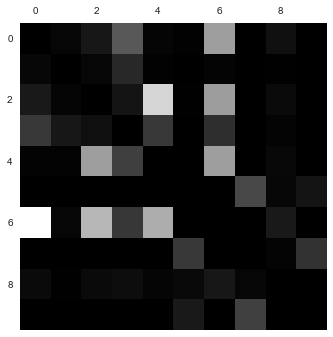

In [92]:
# predict accuracy and plot errors after tuning

# log_reg_final_pred = cross_val_predict(ovo, X_train_reduced, y_train, cv=6, verbose=2)
# joblib.dump(log_reg_final_pred, "FMNIST/pred/log_reg_final_pred.pkl")
log_reg_final_pred = joblib.load(r"FMNIST/pred/log_reg_final_pred.pkl")
display_evaluation(y_train, log_reg_final_pred)

#### Fine-Tune KNN

Accuracy: 0.86267
Display Errors in Confusion Matrix:


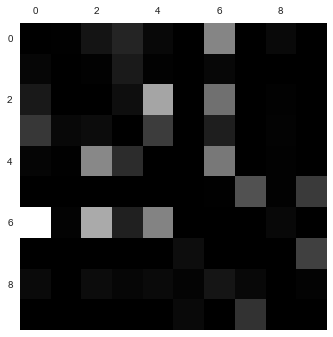

In [93]:
# predict accuracy and plot errors before tuning

# knn_clf_pred = cross_val_predict(knn_clf, X_train_reduced, y_train, cv=6, verbose=2, n_jobs=-1)
# joblib.dump(knn_clf_pred, "FMNIST/pred/knn_clf_pred.pkl")
knn_clf_pred = joblib.load(r"FMNIST/pred/knn_clf_pred.pkl")
display_evaluation(y_train, knn_clf_pred)

> KNN does not output probabilities, which means that it can only be used for hard voting.
In this case, One-vs-Rest, One-vs-One, and a Voting Classifier using soft voting can not be used.

> Tuning weights and penalty:

In [94]:
param_grid = [{
    "weights": ['uniform', 'distance'],
    "p": [1, 2]
}]

In [95]:
# knn_clf_cv = GridSearchCV(KNeighborsClassifier(), param_grid, cv=6, scoring='accuracy', n_jobs=-1, verbose=2)
# knn_clf_cv.fit(X_train_reduced, y_train)
# joblib.dump(knn_clf_cv, "FMNIST/scores/knn_clf_cv.pkl")
knn_clf_cv = joblib.load(r"FMNIST/scores/knn_clf_cv.pkl")

In [96]:
# show the best score
knn_clf_cv.best_score_

0.8694000000000001

In [97]:
# best estimator
knn_clf2 = knn_clf_cv.best_estimator_
knn_clf2

KNeighborsClassifier(p=1, weights='distance')

In [98]:
# show results for each iteration
cvres = knn_clf_cv.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.8670666666666667 {'p': 1, 'weights': 'uniform'}
0.8694000000000001 {'p': 1, 'weights': 'distance'}
0.8626666666666666 {'p': 2, 'weights': 'uniform'}
0.8641166666666668 {'p': 2, 'weights': 'distance'}


> Tuning number of neighbors:
>> Note: There is an even number of classes. It is better to choose an odd number of neighbors to
>> prevent ties.

In [99]:
param_grid = [{
    "n_neighbors": [3, 5, 7, 9, 11, 13, 15]
}]

In [100]:
# knn_clf_cv2 = GridSearchCV(knn_clf2, param_grid, cv=6, scoring='accuracy', n_jobs=-1, verbose=2)
# knn_clf_cv2.fit(X_train_reduced, y_train)
# joblib.dump(knn_clf_cv2, "FMNIST/scores/knn_clf_cv2.pkl")
knn_clf_cv2 = joblib.load(r"FMNIST/scores/knn_clf_cv2.pkl")

In [101]:
# show the best score
knn_clf_cv2.best_score_

0.8694000000000001

In [102]:
# best estimator
knn_clf3 = knn_clf_cv2.best_estimator_
knn_clf3

KNeighborsClassifier(p=1, weights='distance')

In [103]:
# show results for each iteration
cvres = knn_clf_cv2.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.8655333333333334 {'n_neighbors': 3}
0.8694000000000001 {'n_neighbors': 5}
0.8691166666666668 {'n_neighbors': 7}
0.8675833333333333 {'n_neighbors': 9}
0.8665666666666668 {'n_neighbors': 11}
0.8644999999999999 {'n_neighbors': 13}
0.8638666666666666 {'n_neighbors': 15}


> **Final KNN model:** Distance weights, l1 norm and 5 neighbors.
>> Note: The final KNN model has a slightly higher accuracy than the final Logistic Regression model!

Accuracy: 0.8694
Display Errors in Confusion Matrix:


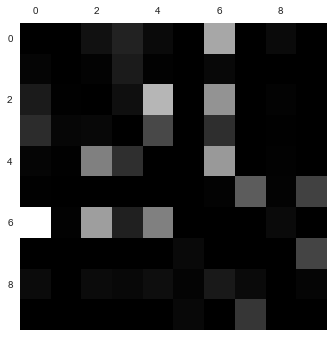

In [104]:
# predict accuracy and plot errors after tuning

# knn_clf_final_pred = cross_val_predict(knn_clf3, X_train_reduced, y_train, cv=6, verbose=2, n_jobs=-1)
## joblib.dump(knn_clf_final_pred, "FMNIST/pred/knn_clf_final_pred.pkl")
knn_clf_final_pred = joblib.load(r"FMNIST/pred/knn_clf_final_pred.pkl")
display_evaluation(y_train, knn_clf_final_pred)

#### Fine-Tune Extra Trees

Accuracy: 0.88215
Display Errors in Confusion Matrix:


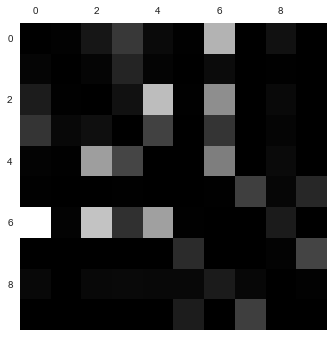

In [105]:
# predict accuracy and plot errors before tuning

# ex_trees_pred = cross_val_predict(ex_trees, X_train_reduced, y_train, cv=6, verbose=2)
# joblib.dump(ex_trees_pred, "FMNIST/pred/ex_trees_pred.pkl")
ex_trees_pred = joblib.load(r"FMNIST/pred/ex_trees_pred.pkl")
display_evaluation(y_train, ex_trees_pred)

> Tuning maximum number features per tree:
>> Note: If this hyperparameter is set to 'None', it evaluates all features. When dealing with high
> dimensional data (such as image classification) it can be convenient to select a smaller amount
> of features.

In [106]:
param_grid = [{
    "max_features": ['sqrt', 0.2, 0.5, 0.8, None]  # max features that are evaluated before splitting a node
}]

In [107]:
# ex_trees_cv = GridSearchCV(ExtraTreesClassifier(random_state=42, n_jobs=-1), param_grid, cv=6,
#                         scoring='accuracy', verbose=2)
# ex_trees_cv.fit(X_train_reduced, y_train)
# joblib.dump(ex_trees_cv, "FMNIST/scores/ex_trees_cv.pkl")
ex_trees_cv = joblib.load(r"FMNIST/scores/ex_trees_cv.pkl")

In [108]:
# show the best score
ex_trees_cv.best_score_

0.8743666666666666

In [109]:
# best estimator
ex_trees2 = ex_trees_cv.best_estimator_
ex_trees2

ExtraTreesClassifier(max_features=None, n_jobs=-1, random_state=42)

In [110]:
# show results for each iteration
cvres = ex_trees_cv.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.8666833333333331 {'max_features': 'sqrt'}
0.8699499999999999 {'max_features': 0.2}
0.8721833333333334 {'max_features': 0.5}
0.8742666666666667 {'max_features': 0.8}
0.8743666666666666 {'max_features': None}


> Tuning number of trees with Bagging and Pasting:
>> Note: More estimators tend to improve accuracy at the expense of increasing the computation time.
> Additionally, from a certain amount of trees the model performance does not change much.

In [111]:
param_grid = [{
    "n_estimators": [50, 100, 200],  # max features in an individual tree
    "bootstrap": [True, False] # sampling with or without replacement
    # True = bagging, False (sklearn default) = pasting
}]

In [112]:
# ex_trees_cv2 = GridSearchCV(ex_trees2, param_grid, cv=6, scoring="accuracy", verbose=2)
# ex_trees_cv2.fit(X_train_reduced, y_train)
# joblib.dump(ex_trees_cv2, "FMNIST/scores/ex_trees_cv2.pkl")
ex_trees_cv2 = joblib.load(r"FMNIST/scores/ex_trees_cv2.pkl")

In [113]:
# show the best score
ex_trees_cv2.best_score_

0.8758500000000001

In [114]:
# best estimator
ex_trees3 = ex_trees_cv2.best_estimator_
ex_trees3

ExtraTreesClassifier(max_features=None, n_estimators=200, n_jobs=-1,
                     random_state=42)

In [115]:
# show results for each iteration
cvres = ex_trees_cv2.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.866 {'bootstrap': True, 'n_estimators': 50}
0.86885 {'bootstrap': True, 'n_estimators': 100}
0.8703499999999998 {'bootstrap': True, 'n_estimators': 200}
0.8709666666666666 {'bootstrap': False, 'n_estimators': 50}
0.8743666666666666 {'bootstrap': False, 'n_estimators': 100}
0.8758500000000001 {'bootstrap': False, 'n_estimators': 200}


> **Final Extra Trees model:** 200 estimators, pasting method (sampling without replacement), and considers
> all features when splitting a node

Accuracy: 0.87585
Display Errors in Confusion Matrix:


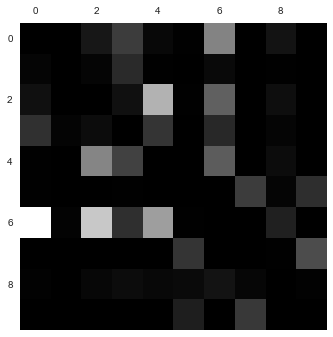

In [119]:
# predict accuracy and plot errors after tuning

# ex_trees_final_pred = cross_val_predict(ex_trees3, X_train_reduced, y_train, cv=6, verbose=2)
# joblib.dump(ex_trees_final_pred, "FMNIST/pred/ex_trees_final_pred.pkl")
ex_trees_final_pred = joblib.load(r"FMNIST/pred/ex_trees_final_pred.pkl")
display_evaluation(y_train, ex_trees_final_pred)

#### Fine-Tune XGBoost

Accuracy: 0.88215
Display Errors in Confusion Matrix:


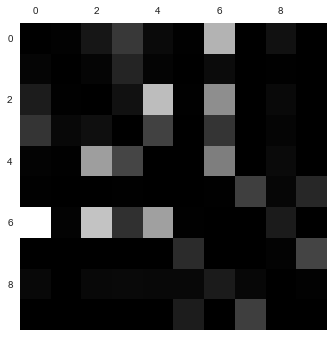

In [122]:
# predict accuracy and plot errors before tuning

xgb_clf_pred = cross_val_predict(xgb_clf, X_train_reduced, y_train, cv=6, verbose=2)
joblib.dump(xgb_clf_pred, "FMNIST/pred/xgb_clf_pred.pkl")
# xgb_clf_pred = joblib.load(r"FMNIST/pred/xgb_clf_pred.pkl")
display_evaluation(y_train, xgb_clf_pred)

> Tuning the number of estimators:

In [123]:
params = {
    "objective": "multi:softmax",
    "num_class": 10,
    "eval_metric": "merror"
}

In [124]:
# xgb_scores_cv1 = cv(params, dmat_train, num_boost_round=200, nfold=6,
#                    early_stopping_rounds=5, seed=42, metrics="merror", verbose_eval=True)
# joblib.dump(xgb_scores_cv1, "FMNIST/scores/xgb_scores_cv1.pkl")
xgb_scores_cv1 = joblib.load(r"FMNIST/scores/xgb_scores_cv1.pkl")

In [125]:
curr_min = xgb_scores_cv1["test-merror-mean"].argmin()
curr_min

121

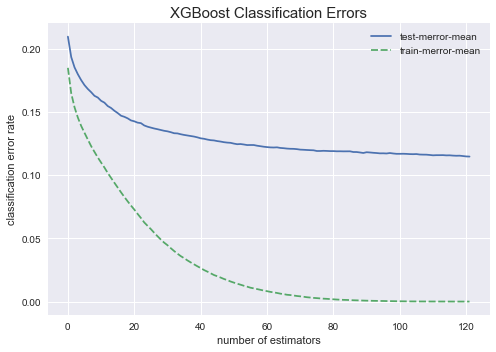

In [126]:
# plot classification errors from cross-validation
plt.figure(figsize=(7, 5))
sns.lineplot(data=[xgb_scores_cv1["test-merror-mean"], xgb_scores_cv1["train-merror-mean"]])
plt.xlabel("number of estimators")
plt.ylabel("classification error rate")
plt.title("XGBoost Classification Errors", size=15)
plt.tight_layout()
plt.show()

In [127]:
# best accuracy
1- xgb_scores_cv1["test-merror-mean"][curr_min]

0.8853

> Tuning learning rate and tree depth:

In [128]:
param_grid = [{
    "max_depth": [3, 4, 5, 6], # maximum depth of a tree
    "learning_rate": [0.1, 0.3] # controls the weights after every boost (eta)
}]

In [129]:
# xgb_scores_cv2 = GridSearchCV(XGBClassifier(random_state=42, n_jobs=-1, eval_metric='merror', objective='multi:softmax',
#                        num_class=10, use_label_encoder=False, n_estimators=122), param_grid, cv=6, scoring='accuracy', verbose=2)
# xgb_scores_cv2.fit(X_train_reduced, y_train)
# joblib.dump(xgb_scores_cv2, "FMNIST/scores/xgb_scores_cv2.pkl")
xgb_scores_cv2 = joblib.load(r"FMNIST/scores/xgb_scores_cv2.pkl")

In [130]:
# show the best score
xgb_scores_cv2.best_score_

0.8841

In [131]:
# best estimator
xgb_clf2 = xgb_scores_cv2.best_estimator_
xgb_clf2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='merror',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=122, n_jobs=-1,
              num_class=10, num_parallel_tree=1, objective='multi:softprob',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [132]:
# show results for each iteration
cvres = xgb_scores_cv2.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.8474333333333334 {'learning_rate': 0.1, 'max_depth': 3}
0.8608666666666668 {'learning_rate': 0.1, 'max_depth': 4}
0.8693499999999998 {'learning_rate': 0.1, 'max_depth': 5}
0.8735666666666666 {'learning_rate': 0.1, 'max_depth': 6}
0.8710166666666668 {'learning_rate': 0.3, 'max_depth': 3}
0.8770000000000001 {'learning_rate': 0.3, 'max_depth': 4}
0.8819 {'learning_rate': 0.3, 'max_depth': 5}
0.8841 {'learning_rate': 0.3, 'max_depth': 6}


In [133]:
param_grid = [{
    "max_depth": [6, 8], # maximum depth of a tree
    "learning_rate": [0.3, 0.5] # controls the weights after every boost (eta)
}]

In [134]:
# xgb_scores_cv3 = GridSearchCV(xgb_clf2, param_grid, cv=6, scoring='accuracy', verbose=2)
# xgb_scores_cv3.fit(X_train_reduced, y_train)
# joblib.dump(xgb_scores_cv3, "FMNIST/scores/xgb_scores_cv3.pkl")
xgb_scores_cv3 = joblib.load(r"FMNIST/scores/xgb_scores_cv3.pkl")

In [135]:
# show the best score
xgb_scores_cv3.best_score_

0.8861333333333334

In [136]:
# best estimator
xgb_clf3 = xgb_scores_cv3.best_estimator_
xgb_clf3

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='merror',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=122, n_jobs=-1,
              num_class=10, num_parallel_tree=1, objective='multi:softprob',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [137]:
# show results for each iteration
cvres = xgb_scores_cv3.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.8841 {'learning_rate': 0.3, 'max_depth': 6}
0.8861333333333334 {'learning_rate': 0.3, 'max_depth': 8}
0.8844833333333334 {'learning_rate': 0.5, 'max_depth': 6}
0.8841000000000001 {'learning_rate': 0.5, 'max_depth': 8}


In [138]:
param_grid = [{
    "max_depth": [8, 10], # maximum depth of a tree
    "learning_rate": [0.3] # controls the weights after every boost (eta)
}]

In [139]:
# xgb_scores_cv4 = GridSearchCV(xgb_clf3, param_grid, cv=6, scoring='accuracy', verbose=2)
# xgb_scores_cv4.fit(X_train_reduced, y_train)
# joblib.dump(xgb_scores_cv4, "FMNIST/scores/xgb_scores_cv4.pkl")
xgb_scores_cv4 = joblib.load(r"FMNIST/scores/xgb_scores_cv4.pkl")

In [140]:
# show the best score
xgb_scores_cv4.best_score_

0.8861333333333334

In [141]:
# best estimator
xgb_clf4 = xgb_scores_cv4.best_estimator_
xgb_clf4

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='merror',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=122, n_jobs=-1,
              num_class=10, num_parallel_tree=1, objective='multi:softprob',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [142]:
# show results for each iteration
cvres = xgb_scores_cv4.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.8861333333333334 {'learning_rate': 0.3, 'max_depth': 8}
0.8846666666666666 {'learning_rate': 0.3, 'max_depth': 10}


> **Final XGBoost model:** 0.3 learning rate, maximum tree depth 8.

Accuracy: 0.88613
Display Errors in Confusion Matrix:


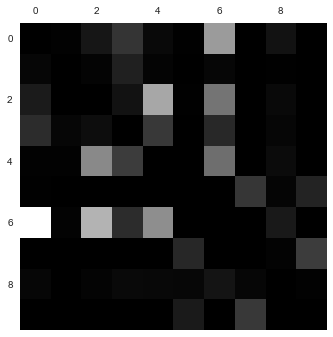

In [143]:
# predict accuracy and plot errors after tuning

# xgb_clf_final_pred = cross_val_predict(xgb_clf4, X_train_reduced, y_train, cv=6, verbose=2)
# joblib.dump(xgb_clf_final_pred, "FMNIST/pred/xgb_clf_final_pred.pkl")
xgb_clf_final_pred = joblib.load(r"FMNIST/pred/xgb_clf_final_pred.pkl")
display_evaluation(y_train, xgb_clf_final_pred)

#### Voting Classifiers
> The voting classifier is an ensemble that aggregates the predictions of multiple classifiers.
> This often leads to higher prediction accuracy.
>> Note: This does not guarantee that the voting classifier will achieve higher accuracy.
> The classifiers were trained on the same data and might make similar errors, so it is preferable
> to use classifiers with diverse algorithms.

> #### Hard Voting Classifier:
> Predicts the class that received the most votes.

In [144]:
voting_hard = VotingClassifier(
    estimators=[
        ('log_reg', clone(log_reg3)),
        ('knn', clone(knn_clf3)),
        ('ex_trees', clone(ex_trees3))],
    voting='hard')

In [145]:
# voting_hard_scores = cross_val_score(voting_hard, X_train_reduced, y_train, cv=6, scoring="accuracy", verbose=2)
# joblib.dump(voting_hard_scores, "FMNIST/scores/voting_hard_scores.pkl")
voting_hard_scores = joblib.load(r"FMNIST/scores/voting_hard_scores.pkl")
display_scores(voting_hard_scores)

Scores: [0.8824 0.8768 0.8817 0.8825 0.8778 0.8807]
Mean: 0.88032
Standard Deviation: 0.00223


Accuracy: 0.88032
Display Errors in Confusion Matrix:


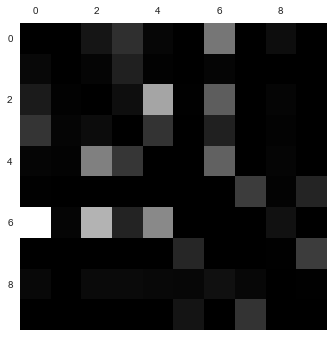

In [147]:
# voting_hard_pred = cross_val_predict(voting_hard, X_train_reduced, y_train, cv=6, verbose=2)
# joblib.dump(voting_hard_pred, "FMNIST/pred/voting_hard_pred.pkl")
voting_hard_pred = joblib.load(r"FMNIST/pred/voting_hard_pred.pkl")
display_evaluation(y_train, voting_hard_pred)

> #### Soft Voting Classifier:
> Averages the predicted probabilities.
>> Note: This voting method is only possible when all classifiers can output predicted probabilities.

In [148]:
voting_soft = VotingClassifier(
    estimators=[
        ('log_reg', clone(log_reg3)),
        ('ex_trees', clone(ex_trees3)),
        ('xgb', clone(xgb_clf3))],
    voting='soft')

In [149]:
# voting_soft_scores = cross_val_score(voting_soft, X_train_reduced, y_train, cv=6, scoring="accuracy", verbose=2)
# joblib.dump(voting_soft_scores, "FMNIST/scores/voing_soft_scores.pkl")
voting_soft_scores = joblib.load(r"FMNIST/scores/voing_soft_scores.pkl")
display_scores(voting_soft_scores)

Scores: [0.8867 0.8828 0.8857 0.8861 0.8848 0.8852]
Mean: 0.88522
Standard Deviation: 0.00124


Accuracy: 0.88522
Display Errors in Confusion Matrix:


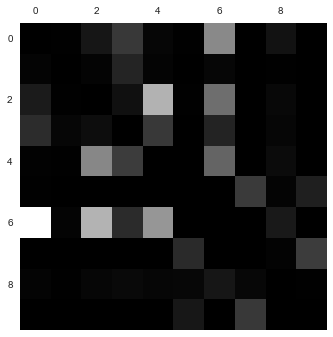

In [150]:
# voting_soft_pred = cross_val_predict(voting_soft, X_train_reduced, y_train, cv=6, verbose=2)
# joblib.dump(voting_soft_pred, "FMNIST/pred/voting_soft_pred.pkl")
voting_soft_pred = joblib.load(r"FMNIST/pred/voting_soft_pred.pkl")
display_evaluation(y_train, voting_soft_pred)

> #### Last Attempt to Improve Accuracy:

Data augmentation is a strategy that is used to create more data from the existing data.
For instance, the images could be rotated. Using this method can add more variation to the data.

As a last attempt to improve model results, I will increase the amount of training data samples.
For each image, I will create 4 new instances by the pixels in different directions (left, right, top, bottom).
Lastly, I will fit the new training instances to the best model and evaluate the results.

As stated earlier, accuracy is sensitive to the test size. Since it would take a very long time to evaluate
before and after augmentation with cross-validation on test sizes of 10,000 instances (30 folds after augmentation!),
I will create a validation set from the training instances and use it to evaluate the best model found- XGBoost.

The validation set will include 10,000 instances, leaving 50,000 for training.

In [156]:
from sklearn.model_selection import train_test_split

X, X_val, y, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=10000)

In [166]:
# make sure that class distribution is equal
y.value_counts().sort_index()

0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
Name: label, dtype: int64

In [168]:
# DataFrame shape (rows, columns)
print("Training Set:", X.shape)
print("Validation Set:", X_val.shape)

Training Set: (50000, 784)
Validation Set: (10000, 784)


> XGBoost model before augmentation:

In [203]:
X_prep = full_pipeline.fit_transform(X)
X_val_prep = full_pipeline.transform(X_val)

Accuracy: 0.8886
Display Errors in Confusion Matrix:


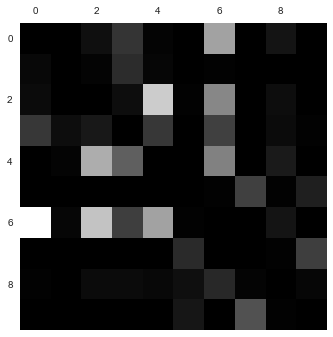

In [204]:
xgb_before = clone(xgb_clf4)
xgb_before.fit(X_prep, y)
joblib.dump(xgb_before, "FMNIST/models/xgb_before.pkl")
# xgb_before = joblib.load(r"FMNIST/models/xgb_before.pkl")
xgb_before_pred = xgb_before.predict(X_val_prep)
joblib.dump(xgb_before_pred, "FMNIST/pred/xgb_before_pred.pkl")
# xgb_before_pred = joblib.load(r"FMNIST/pred/xgb_before_pred.pkl")
display_evaluation(y_val, xgb_before_pred)

In [205]:
#
def shift_image(image, x, y):
    img = np.array(image).reshape(28, 28)
    shifted_img = shift(img, [x, y], cval=0, mode="constant")
    return shifted_img.reshape(-1)

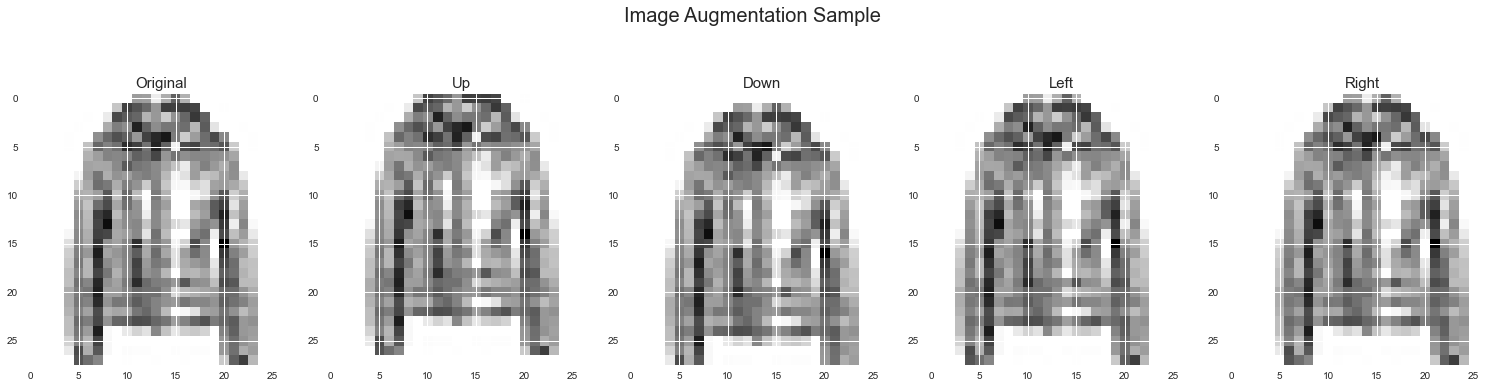

In [206]:
sample_img = X.iloc[5]
img_shifted1 = shift_image(sample_img, -1, 0).reshape(28,28)
img_shifted2 = shift_image(sample_img, 1, 0).reshape(28,28)
img_shifted3 = shift_image(sample_img, 0, -1).reshape(28,28)
img_shifted4 = shift_image(sample_img, 0, 1).reshape(28,28)

fig, ax = plt.subplots(1, 5, figsize=(21,6))
fig.suptitle("Image Augmentation Sample", size=20)
ax[0].imshow(np.array(sample_img).reshape(28,28), cmap="binary")
ax[0].set_title("Original", size=15)
ax[1].imshow(img_shifted1, cmap="binary")
ax[1].set_title("Up", size=15)
ax[2].imshow(img_shifted2, cmap="binary")
ax[2].set_title("Down", size=15)
ax[3].imshow(img_shifted3, cmap="binary")
ax[3].set_title("Left", size=15)
ax[4].imshow(img_shifted4, cmap="binary")
ax[4].set_title("Right", size=15)
plt.tight_layout()
plt.show()

In [207]:
def augmented_dataset(trainX, trainY):
    trainX_arr = np.array(trainX)
    trainY_arr = np.array(trainY)

    trainX_lst = [image for image in trainX_arr] # list containing training images arrays
    trainY_lst = [label for label in trainY_arr] # list containing label values

    for x, y in ((-1, 0), (1, 0), (0, -1), (0, 1)):
        for image, label in zip(trainX_lst, trainY_lst):
            trainX_lst.append(shift_image(image, x, y))
            trainY_lst.append(label)

    # convert data from list to numpy array
    trainX_arr_aug = np.array(trainX_lst)
    trainY_arr_aug = np.array(trainY_lst)

    # shuffle the training instances
    shuffle_idx = np.random.permutation(len(trainX_arr_aug))
    trainX_augmented = trainX_arr_aug[shuffle_idx]
    trainY_augmented = trainY_arr_aug[shuffle_idx]

    return trainX_augmented, trainY_augmented

In [ ]:
X_aug, y_aug = augmented_dataset(X, y)
joblib.dump(X_aug, "FMNIST/data/X_aug.pkl")
joblib.dump(y_aug, "FMNIST/data/y_aug.pkl")
# X_aug = joblib.load(r"FMNIST/data/X_aug.pkl")
# y_aug = joblib.load(r"FMNIST/data/y_aug.pkl")

In [ ]:
# check augmented dataset shape
X_aug.shape

In [ ]:
# check augmented dataset class distribution (should be equal)
y_aug.value_counts().sort_index()

In [ ]:
# use pipeline to transform data
X_aug_prep = full_pipeline.fit_transform(X_aug, y_aug)
X_val_aug_prep = full_pipeline.transform(X_val)

In [ ]:
xgb_after = clone(xgb_clf4)
xgb_after.fit(X_aug_prep, y_aug)
joblib.dump(xgb_after, "FMNIST/models/xgb_after.pkl")
# xgb_after = joblib.load(r"FMNIST/models/xgb_after.pkl")
xgb_after_pred = xgb_after.predict(X_val_aug_prep)
joblib.dump(xgb_after_pred, "FMNIST/pred/xgb_after_pred.pkl")
# xgb_after_pred = joblib.load(r"FMNIST/pred/xgb_after_pred.pkl")
display_evaluation(y_val, xgb_after_pred)

> #### Resources:
1. Fashion MNIST Dataset <a href="https://www.kaggle.com/zalando-research/fashionmnist"
> title="Kaggle">link</a>
2. Feature Scaling Article <a href="https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35"
> title="towardsdatascience">link</a>
3. PCA Article <a href="https://towardsdatascience.com/pca-is-not-feature-selection-3344fb764ae6"
> title="towardsdatascience">link</a>
4. Extra Trees and Random Forest Comparison <a href="https://quantdare.com/what-is-the-difference-between-extra-trees-and-random-forest/"
> title="quantdare">link</a>

In the bootstrap aggregating (bagging) method, part of the original data is
not being used (also called out-of-bag samples).

Sampling without replacement is called pasting.

I'll try to train a Random Forest with the same parameters, this time with pasting
(bagging is the default).

> Tuning leaf node minimum samples and maximum tree depth:
>> Note: Increasing max hyperparameters increase variance and decrease bias. On the other hand,
> increasing min hyperparameters decrease variance and increase bias. It is good to evaluate
> how the different values influence model regularization.

param_grid = [{
#    "min_samples_split": [8, 10, 12], # minimum number of samples required for splitting a node
    "min_samples_leaf": [10, 50, 100],  # minimum number of samples required for a leaf node
    "max_depth": [32, 64]  # maximum depth of a tree
}]

ex_trees_cv3 = RandomizedSearchCV(ex_trees3, param_grid, cv=6, scoring="accuracy", verbose=2, n_iter=10, random_state=42)
ex_trees_cv3.fit(X_train_reduced, y_train)
joblib.dump(ex_trees_cv3, "FMNIST/scores/ex_trees_cv3.pkl")
# ex_trees_cv3 = joblib.load(r"FMNIST/scores/ex_trees_cv3.pkl")

# show the best score
ex_trees_cv3.best_score_

# best estimator
ex_trees4 = ex_trees_cv3.best_estimator_
ex_trees4

# show results for each iteration
cvres = ex_trees_cv3.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

X_arr = np.array(X)
y_arr = np.array(y)

X_train_augmented = [image for image in X_arr] # list containing training images arrays
y_train_augmented = [label for label in y_arr] # list containing label values

for x, y in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_arr, y_arr):
        X_train_augmented.append(shift_image(image, x, y))
        y_train_augmented.append(label)

# convert data from list to numpy array
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

# shuffle the training instances
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]